In [1]:
# =======================
# CONDITIONAL GAN TRAINING
# =======================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
num_classes = 10
image_size = 28 * 28
batch_size = 128
lr = 0.0002
num_epochs = 50

# Prepare dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, z, labels):
        x = torch.cat([z, self.label_emb(labels)], dim=1)
        return self.model(x).view(-1, 1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(image_size + num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        x = torch.cat([img.view(img.size(0), -1), self.label_emb(labels)], dim=1)
        return self.model(x)

# Initialize models
gen = Generator().to(device)
disc = Discriminator().to(device)

# Loss and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.size(0)

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        gen_imgs = gen(z, gen_labels)

        real_loss = criterion(disc(real_imgs, labels), valid)
        fake_loss = criterion(disc(gen_imgs.detach(), gen_labels), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        g_loss = criterion(disc(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        if i % 200 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

# Save the generator
os.makedirs("saved_models", exist_ok=True)
torch.save(gen.state_dict(), "saved_models/cgan_generator.pth")


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 297kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.59MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.6MB/s]


[Epoch 0/50] [Batch 0/469] [D loss: 1.3810] [G loss: 0.6625]
[Epoch 0/50] [Batch 200/469] [D loss: 1.1009] [G loss: 0.9788]
[Epoch 0/50] [Batch 400/469] [D loss: 1.1624] [G loss: 1.2369]
[Epoch 1/50] [Batch 0/469] [D loss: 1.1519] [G loss: 1.2564]
[Epoch 1/50] [Batch 200/469] [D loss: 1.2618] [G loss: 1.5987]
[Epoch 1/50] [Batch 400/469] [D loss: 1.1107] [G loss: 1.3742]
[Epoch 2/50] [Batch 0/469] [D loss: 1.2327] [G loss: 0.8785]
[Epoch 2/50] [Batch 200/469] [D loss: 1.2231] [G loss: 1.2993]
[Epoch 2/50] [Batch 400/469] [D loss: 1.0578] [G loss: 1.2940]
[Epoch 3/50] [Batch 0/469] [D loss: 1.1343] [G loss: 1.9915]
[Epoch 3/50] [Batch 200/469] [D loss: 1.1649] [G loss: 1.1353]
[Epoch 3/50] [Batch 400/469] [D loss: 1.1302] [G loss: 1.5081]
[Epoch 4/50] [Batch 0/469] [D loss: 1.1246] [G loss: 1.0769]
[Epoch 4/50] [Batch 200/469] [D loss: 1.1742] [G loss: 1.0866]
[Epoch 4/50] [Batch 400/469] [D loss: 1.1878] [G loss: 1.2975]
[Epoch 5/50] [Batch 0/469] [D loss: 1.0704] [G loss: 1.3799]
[Epo

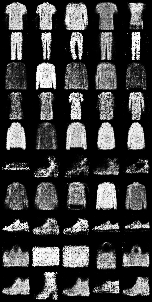

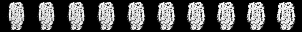

In [2]:
# ===========================
# CONDITIONAL IMAGE GENERATION
# ===========================

import torch
import torch.nn as nn
from torchvision.utils import save_image, make_grid
import os
from PIL import Image
from IPython.display import display

# Setup
latent_dim = 100
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator class (same as in training)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z, labels):
        x = torch.cat([z, self.label_emb(labels)], dim=1)
        return self.model(x).view(-1, 1, 28, 28)

# Load trained generator
gen = Generator().to(device)
gen.load_state_dict(torch.load("saved_models/cgan_generator.pth"))
gen.eval()

# Function to sample images for each class
def sample_images(n_row=5, path="samples/conditional.png"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    z = torch.randn(n_row * 10, latent_dim, device=device)
    labels = torch.arange(0, 10).repeat_interleave(n_row).to(device)
    imgs = gen(z, labels)
    grid = make_grid(imgs, nrow=n_row, normalize=True, value_range=(-1, 1))
    save_image(grid, path)
    display(Image.open(path))

# Function to interpolate between two latent points for one class
def interpolate_label(fixed_label=0, num_steps=10, path="samples/interpolation.png"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    z1 = torch.randn(1, latent_dim, device=device)
    z2 = torch.randn(1, latent_dim, device=device)
    ratios = torch.linspace(0, 1, steps=num_steps).unsqueeze(1).to(device)
    z_interp = z1 * (1 - ratios) + z2 * ratios
    labels = torch.full((num_steps,), fixed_label, dtype=torch.long, device=device)
    with torch.no_grad():
        imgs = gen(z_interp, labels)
    grid = make_grid(imgs, nrow=num_steps, normalize=True, value_range=(-1, 1))
    save_image(grid, path)
    display(Image.open(path))

# Generate and display
sample_images()
interpolate_label(fixed_label=3)  # E.g., class 3 = "Dress"


In [3]:
import torch
from torchvision.utils import save_image
import imageio
from PIL import Image
import os

# ── SETTINGS ─────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
num_classes = 10
start_label = 6   # 6: “Shirt”
end_label   = 7   # 7: “Sneaker” as a proxy for “shoe”
num_frames  = 500
gif_path    = "images/shirt2shoe.gif"
os.makedirs(os.path.dirname(gif_path), exist_ok=True)

# ── LOAD GENERATOR ──────────────────────────────────
# Re-define your Generator exactly as in training
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.label_emb = torch.nn.Embedding(num_classes, num_classes)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(latent_dim + num_classes, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(512, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(1024, 28 * 28),
            torch.nn.Tanh()
        )

    def forward(self, z, labels):
        x = torch.cat([z, self.label_emb(labels)], dim=1)
        return self.model(x).view(-1, 1, 28, 28)

# instantiate and load weights
gen = Generator().to(device)
gen.load_state_dict(torch.load("saved_models/cgan_generator.pth"))
gen.eval()

# ── PREPARE INTERPOLATION ───────────────────────────
# endpoints in noise space
z1 = torch.randn(1, latent_dim, device=device)
z2 = torch.randn(1, latent_dim, device=device)
# endpoints in label-embedding space
c1 = gen.label_emb(torch.tensor([start_label], device=device))
c2 = gen.label_emb(torch.tensor([end_label],   device=device))

# interpolation ratios
ratios = torch.linspace(0, 1, steps=num_frames, device=device).unsqueeze(1)

# linearly interpolate both z and c
z_interp = z1 * (1 - ratios) + z2 * ratios
c_interp = c1 * (1 - ratios) + c2 * ratios

# ── GENERATE FRAMES ─────────────────────────────────
frames = []
with torch.no_grad():
    # feed through the part of your generator after concatenation
    x = torch.cat([z_interp, c_interp], dim=1)
    imgs = gen.model(x).view(num_frames, 1, 28, 28)
    # normalize from (-1,1) → (0,255)
    imgs = ((imgs + 1) * 127.5).clamp(0, 255).byte().cpu()

    for idx in range(num_frames):
        # convert single‐channel tensor to PIL image
        pil_img = Image.fromarray(imgs[idx].squeeze(0).numpy(), mode="L")
        frames.append(pil_img)

# ── SAVE AS GIF ────────────────────────────────────
imageio.mimsave(gif_path, frames, duration=0.03)  # ~30 fps
print(f"Saved interpolation GIF to {gif_path}")


Saved interpolation GIF to images/shirt2shoe.gif
